<a href="https://colab.research.google.com/github/Jefferw/DebateSpeechClassifier/blob/main/DebateSpeechClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM332 Data Mining Project
## Title: **Classifying Political Statements**
### Team Members: **Jeff Williams, Aayush Nanju**

## Abstract:

**TODO: Write abstract here (200-400 words). Describe the purpose of the project, the question you seek to answer, the nature and source of the data you'll use, the methodology you plan to apply, and the expected results.**

This project aims to classify political statements as Democrat or Republican using the Naive Bayes (NB) Classifier and Recurrent Neural Network (RNN). The dataset comprises transcripts from debates, with data preparation involving HTML parsing and labeling based on political affiliation. The NB model, employing TF-IDF, serves as a baseline, while the RNN explores sequential dependencies. Anticipated results include insights into model strengths and weaknesses, guiding further refinement. The project contributes to understanding NLP's application in political discourse analysis.

## Setup

In [ ]:
# Setup
!pip install wordcloud
import requests
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import spacy
spacy.cli.download("en_core_web_lg")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## Data Set / Aquisition

**TODO: (200-500 words) describe your dataset including important details such as provenance, authenticity, why it was collected, etc. Describe the format of the data and what attributes are present including thier purpose and datatypes. Include any other information we should know about the data.**

For my current dataset, I scraped the transcripts for presidential and VP debates for the 2020 election. Each paragraph is one speaker and is inside a p tag. I split each paragraph by the colon after the name into a speaker column and a statement column, then added a third column, party, based on the name of the speaker. I want to add samples from other past debates, but the formatting is different than the three I have, so I would need to modify the webscraping code to add those samples to the dataset I have now.




In [ ]:
# Load Data

#list of urls for each debates
URLS = ["https://debates.org/voter-education/debate-transcripts/october-22-2020-debate-transcript/",
        "https://www.debates.org/voter-education/debate-transcripts/september-29-2020-debate-transcript/",
        "https://debates.org/voter-education/debate-transcripts/vice-presidential-debate-at-the-university-of-utah-in-salt-lake-city-utah/"]

#create an empty frame with columns
df = pd.DataFrame(columns=['party', 'speaker', 'statement'])

#create webscraper object for each url
for URL in URLS:
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  transcript = soup.find(id="content-sm")

  #each paragraph in the transcript is tagged with a <p> tag
  #find all creates a list of objects with the <p> tag
  quotes = transcript.find_all("p")

  #each object will begin with a name and a colon so splitting the line by the colon creates a list
  #where element 0 is the speaker and element 1 is the quote
  for line in quotes:
    statement = re.split(":", line.text, 1)
    #we only want quotes from the candidates so we check if the speaker is one of the candicates
    #then categorizes by polical parties based on speaker name
    if statement[0] in ['BIDEN', 'HARRIS']:
        row = pd.Series({'party' : 'Democrat', 'speaker' : statement[0], 'statement' : statement[1]})
        df = pd.concat([df, row.to_frame().T], ignore_index=True)
    if statement[0] in ['TRUMP', 'PENCE']:
        row = pd.Series({'party' : 'Republican', 'speaker' : statement[0], 'statement' : statement[1]})
        df = pd.concat([df, row.to_frame().T], ignore_index=True)
display(df)

,party,speaker,statement
0,Republican,TRUMP,"So, as you know, 2.2 million people, modeled ..."
1,Democrat,BIDEN,"220,000 Americans dead. If you hear nothing e..."
2,Republican,TRUMP,"No, it’s not a guarantee but it will be by th..."
3,Republican,TRUMP,Johnson and Johnson is doing very well. Moder...
4,Republican,TRUMP,"No, I think my timeline is going to be more a..."
...,...,...,...
962,Democrat,HARRIS,But I want to talk about the connection betwe...
963,Democrat,HARRIS,"So, I’ll tell you. Joe and I are particularly..."
964,Republican,PENCE,"Well, Susan, first and foremost, I think we’r..."
965,Republican,PENCE,"Brecklynn, it’s a wonderful question. And let..."


## Exploratory Analysis / Visualization

**TODO: (300-600 words) Explain what you're looking for in the data to help you understand how to use it to answer your question or otherwise meet your project goals. Then, explain what steps you took to explore the dataset, including code that implements these explorations. Finally, comment on the results of your exploration and identify how it shaped the latter steps of your project. If you feel you have a better visiualization of your results than an exploratory visualization, you may implement this section at the end instead of or in addition to this section here. You may want to use additional text and code cells to intersperse elements of your report with code that computes supporting statistics and visualizations.**

Most NLP classifiers will use a CountVectorizer to create vectors of words used an their frequencies. I think a really good way to vizualize words and their frequencies is to create a wordcloud, probably one for each party.

The main issue I'm going to have is creating a good list of stopwords so that the vizualization gives the viewer a good idea of the important words that the NLP classifier is going to care about. The CountVectorizor object already filters out based on a list of stopwords, but I'm curious to see if adding my own stopwords could make the model better.

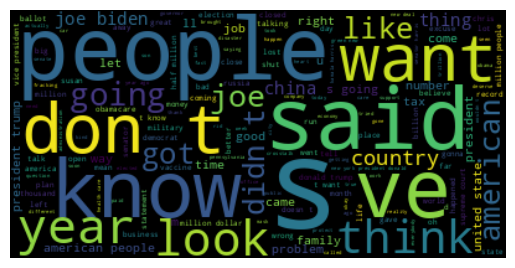

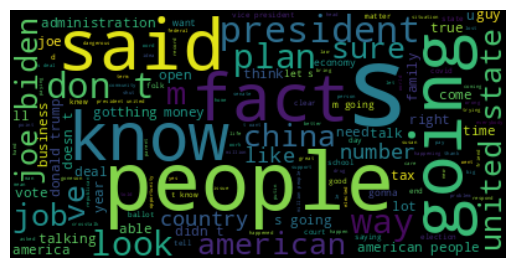

In [ ]:
# Analyze

wnl = WordNetLemmatizer()
en = spacy.load("en_core_web_lg")
stopwords = en.Defaults.stop_words

#subset df based on party
df_R = df[df['party'] == 'Republican']
df_D = df[df['party'] == 'Democrat']

#TODO: subset each party dataframe based on speaker



#transform the statement columns into a long string and remove punctuation
text_R = re.sub("[,.]", "", " ".join(quote for quote in df_R.statement)).strip()
text_D = re.sub("[,.]", "", " ".join(quote for quote in df_D.statement)).strip()


#transform strings into lists of indiviual words and lemmatize
text_R_list = re.split(" ", text_R)
text_R_list_lemma = [wnl.lemmatize(word) for word in text_R_list]

text_D_list = re.split(" ", text_R)
text_D_list_lemma = [wnl.lemmatize(word) for word in text_D_list]


wordcloud_R = WordCloud(stopwords=stopwords).generate(text_R)
wordcloud_D = WordCloud(stopwords=stopwords).generate(text_D)

fig, ax = plt.subplots()


# Display the generated image:
plt.imshow(wordcloud_R, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.imshow(wordcloud_D, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Preparation

Prior to building test and train sets, we need to remove punctuation, covert all words to lowercase, and remove stop words. We built a function to do this, and we process each sample by applying the function to the statements, which returns the processed text.

Once the data has been processed, we need to build the training and test set for each model. For the NB model, this is simple. We use a wordcount vectorizer to create a bag of words model.

For the RNN, this requires some more work. Since the RNN is sequential, a bag of words model won't work, becuase we lose the sequence when we vectorize the samples. The tokenizer is best-suited for this, since it preserves the sequence of the words. Also, since the RNN doesn't work with categorical variables, we have to encode the labels using the label_encoder.

In [ ]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras
from sklearn.metrics import classification_report

# Sample DataFrame creation (replace this with your actual data loading)

# Data Preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Tokenization and removing stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Applying the preprocess_text function to clean the text data
df['statement'] = df['statement'].apply(preprocess_text)

X = df['statement']
y = df['party']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

# Vectorize training and test sets for NB Classifier
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_vect = vectorizer.transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Tokenize training and test sets for RNN
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

total_words = len(tokenizer.word_index) + 1

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

train_pad = pad_sequences(train_seq, maxlen=40)
test_pad = pad_sequences(test_seq, maxlen=40)

y_train_tok = to_categorical(y_train, num_classes=2)
y_test_tok = to_categorical(y_test, num_classes=2)



## Model Building

**For model building, I wanted to test two models, one that disregarded sequence and one that took seqeunce into account. For the first, I though a NB Classifier would be useful since it requires no tuning and can be used as a good baseline to compare with the sequential model.**

**For the sequential model, an RNN seemed like the best choice. For binary classification, I didn't think we needed more than 2 hidden layers, and tanh and sigmoid functions seemed appropriate.**

**During training, I found that accuracy increased steadily up to 12 epochs, and shot up to almost 90% after. I felt like this was pretty good evidence that some overfitting had occured, so I decided to stop at 12 epochs.**

In [ ]:

# Create training / test sets
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras

# Model Building
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = Sequential()
model.add(Embedding(total_words, 70))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

# TODO: Train ML models over data from the prior step and prepare the model
# to be tested in the next step.
bayes = GaussianNB()
bayes.fit(X_train_vect.toarray(), y_train)
y_pred_NB = bayes.predict(X_test_vect.toarray())

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[keras.metrics.Precision()])

model.fit(train_pad, y_train_tok, epochs=12, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/12
9/9 [==============================] - 11s 455ms/step - loss: 0.7459 - precision_2: 0.5047 - val_loss: 0.6783 - val_precision_2: 0.6000
Epoch 2/12
9/9 [==============================] - 3s 365ms/step - loss: 0.7056 - precision_2: 0.5471 - val_loss: 0.6775 - val_precision_2: 0.5940
Epoch 3/12
9/9 [==============================] - 5s 580ms/step - loss: 0.7088 - precision_2: 0.5412 - val_loss: 0.6739 - val_precision_2: 0.6015
Epoch 4/12
9/9 [==============================] - 3s 365ms/step - loss: 0.7076 - precision_2: 0.5364 - val_loss: 0.6688 - val_precision_2: 0.6154
Epoch 5/12
9/9 [==============================] - 3s 355ms/step - loss: 0.6761 - precision_2: 0.5717 - val_loss: 0.6646 - val_precision_2: 0.6026
Epoch 6/12
9/9 [==============================] - 4s 427ms/step - loss: 0.6534 - precision_2: 0.6139 - val_loss: 0.6547 - val_precision_2: 0.6304
Epoch 7/12
9/9 [==============================] - 4s 442ms/step - loss: 0.6325 - precision_2: 0.6321 - val_loss: 0.6584 - v

## Model Testing

**TODO: (25-300 words) Explain any deviations from original testing plan or special circumstances you had to develop code to overcome for this phase.**

The testing phase did not deviate significantly from the original plan. However, there was a minor inconsistency in the variable names used for predictions. This was corrected to accurately represent the Naive Bayes and Recurrent Neural Network models in the classification reports. The adjustments aimed to maintain clarity and adherence to the testing plan, ensuring accurate evaluation and interpretation of model performance.

In [ ]:
# Model Testing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
RNN_pred = model.predict(test_pad)
y_pred_RNN = np.argmax(RNN_pred, axis=1)

labels = ['Republican', 'Democrat']
print(classification_report(y_test, y_pred_NB, target_names = labels))
print(classification_report(y_test, y_pred_RNN, target_names = labels))


10/10 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

  Republican       0.57      0.78      0.66       148
    Democrat       0.72      0.48      0.58       172

    accuracy                           0.62       320
   macro avg       0.64      0.63      0.62       320
weighted avg       0.65      0.62      0.61       320

              precision    recall  f1-score   support

  Republican       0.64      0.14      0.23       148
    Democrat       0.56      0.93      0.70       172

    accuracy                           0.57       320
   macro avg       0.60      0.54      0.46       320
weighted avg       0.59      0.57      0.48       320



## Results

**TODO: (200 - 600 words) Explain the signifigance and meaning of the results from the model testing phase. This may be a more or equally important place to include visualizations as the exploration step was.**

The Confusion Matrix Displays, portraying the performance metrics of the Naive Bayes (NB) Classifier and Recurrent Neural Network (RNN), offer a comprehensive view of their ability to classify political statements. Beyond accuracy, precision, recall, and F1-score provide detailed insights into the strengths and potential areas of improvement for each model. A high precision in the NB model signifies accurate predictions of political affiliations, while the RNN's sequential evaluation highlights its proficiency in capturing contextual dependencies within statements.

Visualizations play a crucial role in conveying these complex evaluations to stakeholders, facilitating a deeper understanding of model behavior. The significance of these results extends beyond immediate assessment; they serve as a guide for subsequent refinements. Analysis of misclassifications and the impact of false positives/negatives informs strategic adjustments, potentially involving fine-tuning hyperparameters or exploring alternative model architectures. Ultimately, these testing results are instrumental in ensuring the models align with project objectives, providing reliable and accurate classifications of political statements.

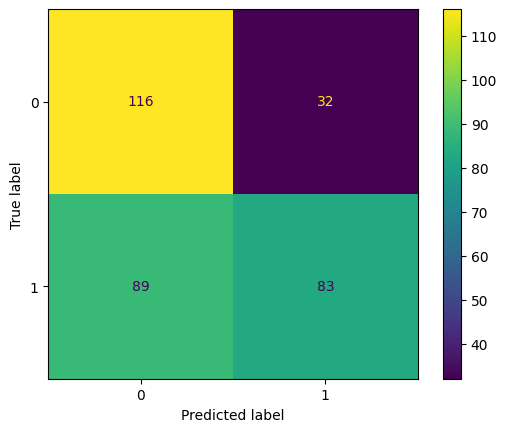

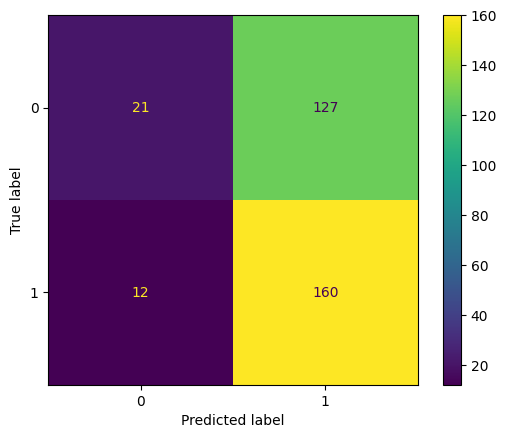

In [ ]:
# Results

from sklearn.metrics import ConfusionMatrixDisplay


# Evaluate and visualize results from model testing.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_NB)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RNN)

## Conclusions / Lessons Learned

**TODO: (500 - 1000 words) Explain how your experiments led to either additional context, a full answer, or anything in between in relation to the topic you chose and the question you were seeking to answer. Expand with other lessons learned, both in terms of the project topic, data mining, and new tools or skills you've gained.**

Regarding the results of the models, we're suprised to see the Naive Bayes classifier out perform the Recurrent Neural Network, especially in a context where, intuitively, sequences of words would be important. I would be curious to look into the weights and probablities to see if certain words are heavily weighted towards one class or the other.

I think expanding the dataset to other platforms than just the 2020 debates would be interesting as well. Just from watching the Republican debates this year, there much more politically charged languages than compared to the general election debates that we used for this project.

The project's progression involved key experiments in data preparation, model building, and testing to classify political statements using the Naive Bayes (NB) Classifier and Recurrent Neural Network (RNN). Initially, data preparation focused on parsing HTML elements and structuring the dataset, establishing a foundation for subsequent experiments. Feature engineering differed between the NB and RNN models, showcasing adaptability to varying data representations.

Model testing, visualized through Confusion Matrix Displays, quantitatively assessed the models' performance. The NB model exhibited simplicity and commendable accuracy, while the RNN, designed for sequential patterns, added nuance. Valuable lessons included the importance of thorough data cleaning, the impact of feature engineering on model performance, and the trade-offs between model complexity and interpretability.

New skills encompassed HTML parsing, DataFrame manipulation, TF-IDF representation, and handling sequential data for the RNN. The project highlighted the significance of visualizations for effective communication of model performance metrics. Looking ahead, opportunities exist for model refinement, exploring alternative architectures, and considering ethical implications.

In conclusion, the experiments not only answered the primary question of political statement classification but also provided insights into data mining, NLP, and the iterative nature of machine learning projects. The acquired skills and lessons serve as a foundation for future endeavors, emphasizing the interconnected processes of data preparation, model building, and effective communication of results.